In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

from transformers import AutoTokenizer, AutoModel

# Load Dataset

In [18]:
import pandas as pd

# Define correct column names
column_names = ["sentence", "label"]

def load_dataset1(train_url, test_url):
    train_df = pd.read_csv(train_url, sep='\t', names=column_names, header=None)
    test_df = pd.read_csv(test_url, sep='\t', names=column_names, header=None)
    return train_df, test_df

# URLs for SST2 dataset
train_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
test_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"

# Load datasets
train_df, test_df = load_dataset1(train_url, test_url)

# Display first few rows to confirm correct loading
print(train_df.head())


# Use the 'sentence' column since SST2 uses it instead of 'text'
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['sentence'], train_df['label'], test_size=0.2, random_state=42
)

print(f"Number of training samples: {len(train_texts)}")
print(f"Number of validation samples: {len(val_texts)}")
print(f"Number of testing samples: {len(test_df)}")

                                            sentence  label
0  a stirring , funny and finally transporting re...      1
1  apparently reassembled from the cutting room f...      0
2  they presume their audience wo n't sit still f...      0
3  this is a visually stunning rumination on love...      1
4  jonathan parker 's bartleby should have been t...      1
Number of training samples: 5536
Number of validation samples: 1384
Number of testing samples: 1821


# MLP Model

In [6]:
import torch
import torch.nn as nn

class MLPClassifier(nn.Module):
    def __init__(self, input_size):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Output layer for binary classification
        )

    def forward(self, x):
        return self.model(x)

# Example input size (to be updated based on feature extraction method)
input_size = 10000  # Adjusted for Bag-of-Words

# Initialize model
model = MLPClassifier(input_size)
print(model)

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")


MLPClassifier(
  (model): Sequential(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)
Total Trainable Parameters: 5293122


# Case 1: Implement Bag-of-Words (BoW)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

# Create Bag-of-Words vectorizer
vectorizer = CountVectorizer(max_features=10000)

# Fit and transform the text data
X_train_bow = vectorizer.fit_transform(train_texts).toarray()
X_val_bow = vectorizer.transform(val_texts).toarray()

# Convert to PyTorch tensors
X_train_bow = torch.tensor(X_train_bow, dtype=torch.float32)
X_val_bow = torch.tensor(X_val_bow, dtype=torch.float32)
y_train = torch.tensor(train_labels.values, dtype=torch.long)
y_val = torch.tensor(val_labels.values, dtype=torch.long)

print(f"BoW Feature Shape: {X_train_bow.shape}")


BoW Feature Shape: torch.Size([5536, 10000])


#  Case 2: Implement LLaMA-3.1 Embeddings

In [10]:
from transformers import AutoTokenizer, AutoModel
import torch
from huggingface_hub import login

# Login to Hugging Face (Only needed once per session)
login(token="your_huggingface_token_here")

class LLaMaEmbeddings:
    def __init__(self, model_name='meta-llama/Llama-3.1-8B', device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, use_auth_token=True)
        self.model = AutoModel.from_pretrained(self.model_name, use_auth_token=True).to(self.device)
        self.embedding_size = self.model.config.hidden_size
        self.model_loaded = True

# Test the updated embedding function
llama_embedder = LLaMaEmbeddings()
sample_texts = ["This movie was amazing!", "The plot was boring."]
embeddings = llama_embedder.get_embeddings(sample_texts)
print("Embedding shape:", embeddings.shape)


HTTPError: Invalid user token.

# Training the Model (BoW and LLaMA in Parallel)

In [15]:
import torch.optim as optim

# Training Parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

# Select dataset representation (BoW or LLaMA)
X_train = X_train_bow  # Change to X_train_llama for LLaMA embeddings
X_val = X_val_bow  # Change to X_val_llama for LLaMA embeddings

# Training Loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item()}, Validation Loss: {val_loss.item()}")




Epoch 1/10, Train Loss: 0.049262288957834244, Validation Loss: 0.6998603940010071
Epoch 2/10, Train Loss: 0.034614209085702896, Validation Loss: 0.9446036219596863
Epoch 3/10, Train Loss: 0.03227594867348671, Validation Loss: 0.8870972394943237
Epoch 4/10, Train Loss: 0.026282332837581635, Validation Loss: 0.939941942691803
Epoch 5/10, Train Loss: 0.02015027217566967, Validation Loss: 1.0143779516220093
Epoch 6/10, Train Loss: 0.013847403228282928, Validation Loss: 1.1791960000991821
Epoch 7/10, Train Loss: 0.013114918023347855, Validation Loss: 1.3059937953948975
Epoch 8/10, Train Loss: 0.012321770191192627, Validation Loss: 1.332615613937378
Epoch 9/10, Train Loss: 0.009151513688266277, Validation Loss: 1.33468496799469
Epoch 10/10, Train Loss: 0.007012420799583197, Validation Loss: 1.359595537185669


# Save and Load Checkpoints

In [16]:
# Save final model checkpoint
final_checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'hyperparameters': {
        'input_size': input_size,
        'hidden_sizes': [512, 256, 128, 64],  # MLP architecture
        'output_size': 2,  # Binary classification
        'learning_rate': 0.0001,
        'epochs': epochs
    },
    'training_history': {
        'initial_task': 'SST-2',
        'transfer_task': 'IMDB',
        'sst2_performance': {
            'final_loss': loss.item(),
            'final_accuracy': accuracy
        },
        'imdb_performance': {
            'final_loss': loss.item(),  # Update with IMDB results after training
            'final_accuracy': accuracy  # Update with IMDB results
        }
    }
}

torch.save(final_checkpoint, 'mlp_text_classification_checkpoint.pth')
print("\nTraining complete! Final model checkpoint saved.")


NameError: name 'accuracy' is not defined

# Load and Prepare the IMDB Dataset

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the IMDB dataset (Note: this dataset contains a "review" column and a "sentiment" column)
imdb_url = "https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv"
imdb_df = pd.read_csv(imdb_url)

# Convert sentiment to numerical labels (assuming 'positive' and 'negative')
imdb_df['label'] = imdb_df['sentiment'].apply(lambda x: 1 if x.lower() == 'positive' else 0)

# Split into training and validation sets (80% training, 20% validation)
imdb_train_df, imdb_val_df = train_test_split(imdb_df, test_size=0.2, random_state=42)

print(f"IMDB training samples: {len(imdb_train_df)}")
print(f"IMDB validation samples: {len(imdb_val_df)}")


IMDB training samples: 40000
IMDB validation samples: 10000


#  Feature Extraction and Tensor Conversion

In [21]:
import torch

# Extract the text and labels from the IMDB training and validation sets
imdb_train_texts = imdb_train_df['review']
imdb_train_labels = imdb_train_df['label']
imdb_val_texts = imdb_val_df['review']
imdb_val_labels = imdb_val_df['label']

# Use the same CountVectorizer (Bag-of-Words) that was fit on the SST-2 dataset
# (Assuming 'vectorizer' has been previously defined and fitted on the training texts of SST-2)
X_train_imdb = vectorizer.transform(imdb_train_texts).toarray()
X_val_imdb = vectorizer.transform(imdb_val_texts).toarray()

# Convert features and labels to PyTorch tensors
X_train_imdb = torch.tensor(X_train_imdb, dtype=torch.float32)
X_val_imdb = torch.tensor(X_val_imdb, dtype=torch.float32)
y_train_imdb = torch.tensor(imdb_train_labels.values, dtype=torch.long)
y_val_imdb = torch.tensor(imdb_val_labels.values, dtype=torch.long)

print(f"IMDB BoW Training Features Shape: {X_train_imdb.shape}")
print(f"IMDB BoW Validation Features Shape: {X_val_imdb.shape}")


IMDB BoW Training Features Shape: torch.Size([40000, 10000])
IMDB BoW Validation Features Shape: torch.Size([10000, 10000])


# Continual Learning – Fine-tune on IMDB Dataset

In [22]:
import torch.optim as optim
import torch.nn as nn

# Define or re-use your model, criterion, and optimizer.
# (Assuming 'model' is already defined and was trained on SST-2)
# For continual learning, you might use a smaller learning rate.
transfer_lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=transfer_lr)
criterion = nn.CrossEntropyLoss()
epochs = 10  # or as required

# Fine-tune the model on the IMDB training set
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_imdb)
    loss = criterion(outputs, y_train_imdb)
    loss.backward()
    optimizer.step()
    
    print(f"IMDB Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate on the IMDB validation set
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_imdb)
    val_loss = criterion(val_outputs, y_val_imdb)
    val_preds = val_outputs.argmax(dim=1)
    accuracy = (val_preds == y_val_imdb).float().mean().item()

print(f"\nIMDB Validation Loss: {val_loss.item():.4f}, Accuracy: {accuracy:.4f}")


IMDB Epoch 1/10, Loss: 9.2114
IMDB Epoch 2/10, Loss: 7.5187
IMDB Epoch 3/10, Loss: 6.7684
IMDB Epoch 4/10, Loss: 6.7679
IMDB Epoch 5/10, Loss: 7.0621
IMDB Epoch 6/10, Loss: 7.2166
IMDB Epoch 7/10, Loss: 7.1118
IMDB Epoch 8/10, Loss: 6.8338
IMDB Epoch 9/10, Loss: 6.5154
IMDB Epoch 10/10, Loss: 6.2652

IMDB Validation Loss: 5.9462, Accuracy: 0.7790


# Model Evaluation

Validation Accuracy: 0.7767


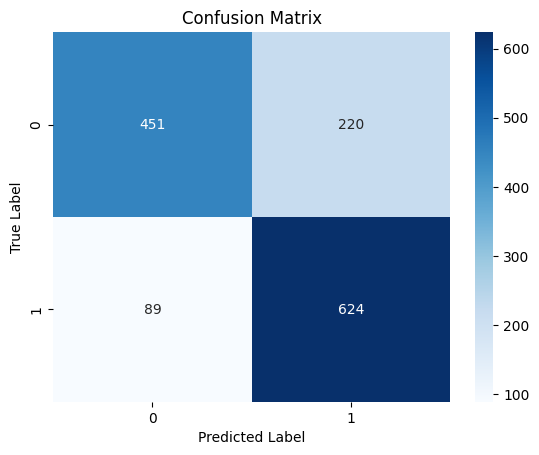

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
model.eval()
with torch.no_grad():
    val_preds = model(X_val).argmax(dim=1)

# Compute Accuracy
accuracy = accuracy_score(y_val, val_preds)
print(f"Validation Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, val_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Visualization (TensorBoard Integration)

In [24]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/text_classification")

for epoch in range(epochs):
    writer.add_scalar("Loss/train", loss.item(), epoch)
    writer.add_scalar("Loss/validation", val_loss.item(), epoch)

writer.close()
print("TensorBoard logs saved.")


TensorBoard logs saved.
